In [1]:
# ! pip install pandas
# ! pip install numpy
# ! pip install matplotlib
# ! pip install pmdarima
# ! pip install arch

In [2]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as scs
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
#from arch import arch_model
from arch.univariate import HARX
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)


# Task 1

### Task 1.1

In [3]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('content/IBM_202001.csv.gz', compression='gzip')

# Display the first few rows of the DataFrame
print(df.shape)
print(df.columns)
df.head()


(985176, 11)
Index(['DATE', 'TIME_M', 'SYM_ROOT', 'EX', 'SIZE', 'PRICE', 'NBO', 'NBB',
       'NBOqty', 'NBBqty', 'BuySell'],
      dtype='object')


,DATE,TIME_M,SYM_ROOT,EX,SIZE,PRICE,NBO,NBB,NBOqty,NBBqty,BuySell
0,02JAN2020,34200.226,IBM,P,1.0,135.10,135.1,134.88,500.0,100.0,1.0
1,02JAN2020,34200.226,IBM,P,1.0,135.10,135.1,134.88,500.0,100.0,1.0
2,02JAN2020,34200.381,IBM,K,1.0,135.09,135.1,134.62,500.0,600.0,1.0
3,02JAN2020,34200.600,IBM,N,74082.0,135.00,135.1,134.62,500.0,600.0,1.0
4,02JAN2020,34200.600,IBM,N,74082.0,135.00,135.1,134.62,500.0,600.0,1.0


In [4]:
original_length = len(df)
data = df.copy()
original_length

985176

In [5]:
# Removing entries with either transaction price, transaction size, ask price, ask size, bid price or bid size ≤ 0
df_out = (df['NBB'] <= 0) | (df['NBBqty'] <= 0) |  (df['NBO'] <= 0) | (df['NBOqty'] <= 0) | (df['PRICE'] <= 0) | (df['SIZE'] <= 0)
df = df[~df_out].reset_index(drop=True)

# calculating no. of entries removed in f1
f1 = original_length - len(df)
f1_cleaned_length = len(df)
print(f1)

0


In [6]:
# Remove entries with negative bid-ask spread
df['SPREAD'] = df['NBO'] - df['NBB']
df = df[~(df['SPREAD'] <= 0)].reset_index(drop=True)

f2 = f1_cleaned_length - len(df)
f2_cleaned_length = len(df)
print(f2)

14375


In [7]:
df['Stamp'] = pd.to_datetime(df['DATE'], format='%d%b%Y') + df['TIME_M'].apply(lambda x: pd.Timedelta(x,unit='sec'))

In [8]:
# Group by 'DATE', 'TIME', 'EX', and 'BuySell'
df = df.groupby(['Stamp', 'DATE', 'EX', 'BuySell']).agg({
    'PRICE': 'median',
    'NBO': 'median',
    'NBB': 'median',
    'SIZE': 'sum',
    'NBOqty': 'sum',
    'NBBqty': 'sum'
}).reset_index()

f3 = f2_cleaned_length - len(df)
f3_cleaned_length = len(df)
print(f3)

222406


In [9]:
# Remove entries for which the spread is more that 50 times the median spread on that day
df['SPREAD'] = df['NBO'] - df['NBB']

medspread = df['SPREAD'].median()
df = df[~(df['SPREAD'] > 50*medspread)].reset_index(drop=True)

f4 = f3_cleaned_length - len(df)
f4_cleaned_length = len(df)
print(f4)

0


In [10]:
## Delete entries with prices that are above the `ask' plus the bid–ask spread. 
## Similar for entries with prices below the `bid' minus the bid–ask spread
df_out = (df['PRICE'] > df['NBO'] + df['SPREAD']) | (df['PRICE'] < df['NBB'] - df['SPREAD'])
df = df[~df_out]

f5 = f4_cleaned_length - len(df)
f5_cleaned_length = len(df)
print(f5)

7063


In [11]:
summary = pd.DataFrame({
    'F1': [f1, f1/original_length*100],
    'F2': [f2, f2/original_length*100],
    'F3': [f3, f3/original_length*100],
    'F4': [f4, f4/original_length*100],
    'F5': [f5, f5/original_length*100],
}, index=['Number', 'Proportion'])
summary.round(2)

,F1,F2,F3,F4,F5
Number,0.0,14375.00,222406.00,0.0,7063.00
Proportion,0.0,1.46,22.58,0.0,0.72


### Task 1.2

In [12]:
df.set_index('Stamp', drop=True, inplace = True)

In [20]:
df['Return'] = np.log(df['PRICE']/df['PRICE'].shift(1))
returns = df['Return'].dropna()

# Assuming 'df' is your DataFrame containing the dataset
# Convert 'Stamp' column to datetime if it's not already in datetime format

# Function to compute Realized Volatility (RV)
def realized_volatility(returns):
    return np.sum(returns ** 2)

# Function to compute Bipower Variation (BV)
def bipower_variation(returns):
    ret = np.absolute(returns).values
    return np.pi/2*sum(ret[0:-1]*ret[1:])

# Function to compute Truncated Realized Volatility (TRV)
def truncated_realized_volatility(returns, RV, BV):
    ret = np.absolute(returns).values
    u = 3/np.sqrt(len(ret))*np.sqrt(min(RV,BV))
    return sum(ret**2*(ret <= u))

# Resample at different frequencies and compute measures
sampling_frequencies = ['1s', '2s', '3s', '4s', '5s', '10s', '15s', '20s', '30s', 
                        '40s', '50s', '1min', '2min', '3min', '4min', '5min', 
                        '6min', '7min', '8min', '9min', '10min', '15min', '20min', '30min']

RVdf = pd.DataFrame(index=pd.unique(df.index.date), columns=sampling_frequencies)
BVdf = pd.DataFrame(index=pd.unique(df.index.date), columns=sampling_frequencies)
TRVdf = pd.DataFrame(index=pd.unique(df.index.date), columns=sampling_frequencies)

for date in pd.unique(df.index.date):
    daily_data = df[df.index.date == date].copy()
    daily_data.dropna(inplace= True)
    for freq in sampling_frequencies:
        resampled_data = daily_data.resample(rule=freq,closed ='right',label ='right').apply('sum')
        returns = resampled_data['Return']
        RV = realized_volatility(returns)
        BV = bipower_variation(returns)
        TRV = truncated_realized_volatility(returns, RV, BV)
        RVdf.at[date, freq] = RV
        BVdf.at[date, freq] = BV
        TRVdf.at[date, freq] = TRV
        

RVdf = RVdf*10000
BVdf = BVdf*10000
TRVdf = TRVdf*10000

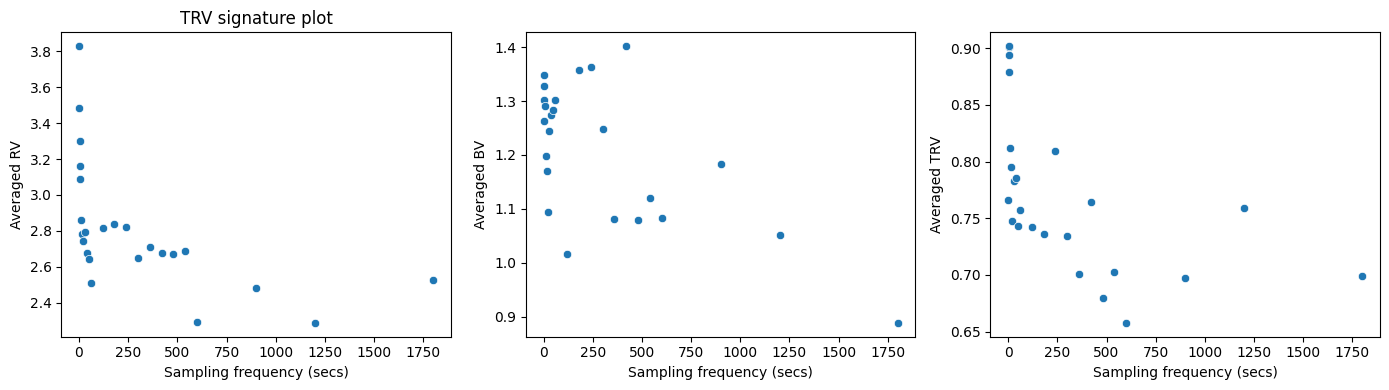

In [21]:

# Compute Average RVs across different days
RVav = RVdf.mean()
# Convert index to integers (sec)
RVav.index
time_RV = [0] + [pd.Timedelta(x).total_seconds() for x in RVav.index[1:]]


# Compute Average RVs across different days
BVav = BVdf.mean()
# Convert index to integers (sec)
BVav.index
time_BV = [0] + [pd.Timedelta(x).total_seconds() for x in BVav.index[1:]]


# Compute Average RVs across different days
TRVav = TRVdf.mean()
# Convert index to integers (sec)
TRVav.index
time_TRV = [0] + [pd.Timedelta(x).total_seconds() for x in TRVav.index[1:]]



fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(14,4))

sns.scatterplot(x=time_RV,y=RVav,ax=axes[0])
axes[0].set_title('RV signature plot')
axes[0].set_xlabel('Sampling frequency (secs)')
axes[0].set_ylabel('Averaged RV')

sns.scatterplot(x=time_BV,y=BVav,ax=axes[1])
axes[0].set_title('BV signature plot')
axes[1].set_xlabel('Sampling frequency (secs)')
axes[1].set_ylabel('Averaged BV')

sns.scatterplot(x=time_TRV,y=TRVav,ax=axes[2])
axes[0].set_title('TRV signature plot')
axes[2].set_xlabel('Sampling frequency (secs)')
axes[2].set_ylabel('Averaged TRV')

plt.tight_layout()

# Task 2

### Task 2.1

In [1]:
print('This is task 2')

This is task 2
